In [1]:
from multiprocessing import Pool
import igraph
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import stats
import time 

# Import clock, accomodating different versions of time library
try:
    clock = time.clock
except AttributeError:
    clock = lambda : time.clock_gettime(1)
import copy

# Display options
np.set_printoptions(precision=2)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from matplotlib import rc

import matplotlib as mpl
import seaborn as sns
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Computer Modern Sans serif"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

# Local modules
import sys
sys.path.append("modules/")
import sampling
import unbiased_estimation
import utils

# Set pool_size for multiprocessing 
pool_size = 18

# Setup 

In [2]:
def plot_chains(data, clusts1, clusts2, save_name=None):
    f, axarr = plt.subplots(ncols=2)
    utils.plot_clusts(data, clusts1, axarr[0])
    utils.plot_clusts(data, clusts2, axarr[1])
    if save_name is not None: plt.savefig(save_name)
    plt.show()

In [3]:
def ex6_gen_data(Ndata, sd, sd0=1, K=2, dp_alpha=10):
    # TRANSLATION OF TAMARA BRODERICK's CODE INTO PYTHON 
    # (https://github.com/tbroderick/mlss2015_bnp_tutorial)
    #
    # generate Gaussian mixture model data for inference later
    #
    # Args:
    #  Ndata: number of data points to generate
    #  sd: covariance matrix of data points around the
    #      cluster-specific mean is [sd^2, 0; 0, sd^2];
    #      i.e. this is the standard deviation in either direction
    #  sd0: std for prior mean
    #
    # Returns:
    #  x: an Ndata x 2 matrix of data points
    #  z: an Ndata-long vector of cluster assignments
    #  mu: a K x 2 matrix of cluster means,
    #      where K is the number of clusters

    # matrix of cluster centers: one in each quadrant
    mu = np.random.normal(scale=sd0, size=[K, 2])
    # vector of component frequencies
    rho = stats.dirichlet.rvs(alpha=dp_alpha*np.ones(K))[0]

    # assign each data point to a component
    z = np.random.choice(range(K), p=rho, replace=True, size=Ndata)
    # draw each data point according to the cluster-specific
    # likelihood of its component
    x = mu[z] + np.random.normal(scale=sd, size=[Ndata,2])  
    
    return x

In [4]:
def crp_gibbs_couple(
    data, sd, sd0, initz1, initz2,alpha=0.01, plot=True,
    log_freq=None, maxIters=100, coupling="Maximal", save_base=None):
    """
    
    Args:
        coupling: method of coupling must be "Common_RNG", "Maximal" or "Optimal" ("Common_RNG" used to be "Naive")
    
    """
    
    # initialize the sampler
    z1, z2 = initz1, initz2
    z1s, z2s = [z1.copy()], [z2.copy()]
    
    dists_by_iter = []
    
    # set frequency at which to log state of the chain
    if log_freq is None: log_freq = int(maxIters/10)
    
    # run the Gibbs sampler
    for I in range(maxIters):
            
        z1, z2 = sampling.gibbs_sweep_couple(
            data, z1.copy(), z2.copy(), sd, sd0,
            alpha=alpha, coupling=coupling)
            
        # data counts at each cluster
        clusts1, clusts2 = utils.z_to_clusts(z1), utils.z_to_clusts(z2)  
        z1s.append(z1); z2s.append(z2)
        
        # compute and log distance between partitions
        dist_between_partitions = utils.adj_dists_fast(clusts1, clusts2)
        dists_by_iter.append(dist_between_partitions)
        
        if (I%log_freq==0 or dist_between_partitions==0) and plot:
            print("Iteration %04d/%04d"%(I, maxIters))
            print("n_clusts: ", len(clusts1), len(clusts2))
            save_name = save_base + "_%04d.png"%I if save_base is not None else None
            plot_chains(data, clusts1, clusts2, save_name=save_name)
            
        if dist_between_partitions == 0: break
        
    return z1, dists_by_iter

# Figure 1A

In [5]:
def run_rep(K, Ndata, sd=2., sd0=2., alpha=0.5, lag=200, maxIters=int(1e5)):
    """run_rep runs a replicate and returns the trace and time to coupling for maximal and optimal couplings"""
    np.random.seed() # set random seed in each process so multi-processing replicates are not identical.
    data = ex6_gen_data(Ndata, sd, sd0, K=K)
    initz1 = sampling.crp_gibbs(data, sd, sd0, initz, alpha=alpha, plot=False, maxIters=lag)
    initz2 = initz.copy()
    
    # simulate maximal coupling
    st = clock()
    _, trace_maximal = crp_gibbs_couple(
        data, sd, sd0, initz1.copy(), initz2.copy(), alpha=alpha, plot=False, maxIters=maxIters,
        coupling="Maximal", save_base=None)
    end = clock()
    time_maximal = end-st
    
    # simulate common rng coupling
    st = clock()
    _, trace_rng = crp_gibbs_couple(
        data, sd, sd0, initz1.copy(), initz2.copy(), alpha=alpha, plot=False, maxIters=maxIters,
        coupling="Common_RNG", save_base=None)
    end = clock()
    time_rng = end-st
    
    # simulate optimal coupling
    st = clock()
    _, trace_optimal = crp_gibbs_couple(
        data, sd, sd0, initz1.copy(), initz2.copy(), alpha=alpha, plot=False, maxIters=maxIters,
        coupling="Optimal", save_base=None)
    end = clock()
    time_optimal = end-st
    
    return trace_maximal, trace_optimal, trace_rng, time_maximal, time_optimal, time_rng

In [6]:
n_reps = 250
Ndata, K, sd, sd0, alpha = 150, 4, 2., 2.5, 0.2
initz = np.zeros(Ndata, dtype=np.int)
lag = 250 # number of lag iterations
maxIters = 2000

traces_by_coupling = {"Optimal":[], "Maximal":[], "Common_RNG":[]}
times_by_coupling = {"Optimal":[], "Maximal":[], "Common_RNG":[]}


run_in_parallel = True
if run_in_parallel:
    def simulate(rep):
        result = run_rep(K=K, Ndata=Ndata, sd=sd, sd0=sd0, alpha=alpha, lag=lag, maxIters=maxIters)
        return result
    with Pool(pool_size) as p:
        results = p.map(simulate, range(n_reps))
    
    for (trace_maximal, trace_optimal, trace_rng, time_maximal, time_optimal, time_rng) in results:
        traces_by_coupling["Optimal"].append(trace_optimal)
        traces_by_coupling["Maximal"].append(trace_maximal)
        traces_by_coupling["Common_RNG"].append(trace_rng)
        times_by_coupling["Optimal"].append(time_optimal)
        times_by_coupling["Maximal"].append(time_maximal)
        times_by_coupling["Common_RNG"].append(time_rng)
else:
    for rep in range(n_reps):
        trace_maximal, trace_optimal, trace_rng, time_maximal, time_optimal, time_rng = run_rep(
            K=K, Ndata=Ndata, sd=sd, sd0=sd0, alpha=alpha, lag=lag, maxIters=maxIters)
        traces_by_coupling["Optimal"].append(trace_optimal)
        traces_by_coupling["Maximal"].append(trace_maximal)
        traces_by_coupling["Common_RNG"].append(trace_rng)
        times_by_coupling["Optimal"].append(time_optimal)
        times_by_coupling["Maximal"].append(time_maximal)
        times_by_coupling["Common_RNG"].append(time_rng)

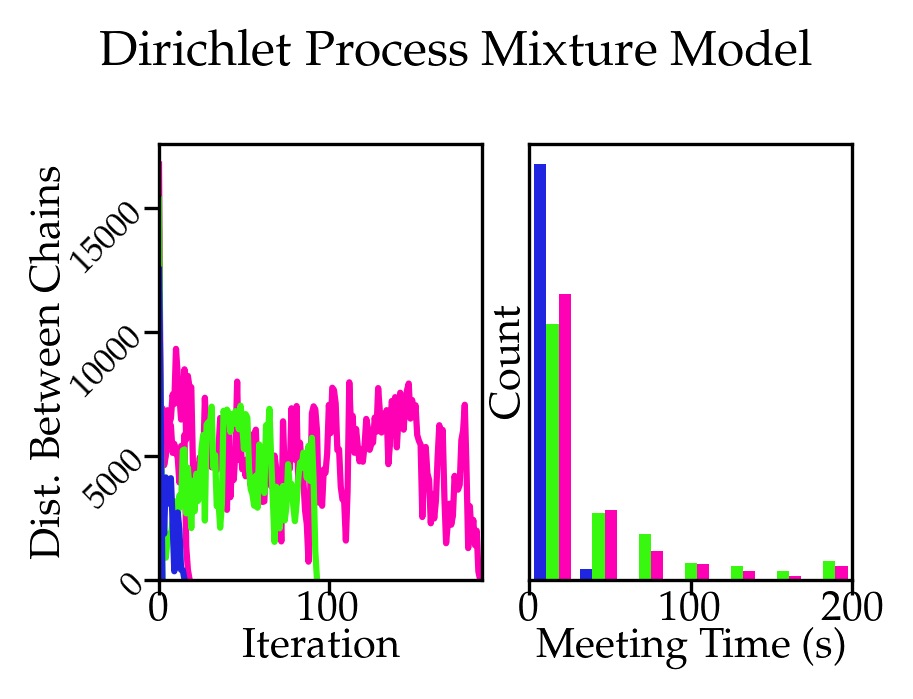

In [7]:
dirname = "figure1_results/"
if not os.path.exists(dirname):
    print("Will make directory %s" %dirname)
    os.makedirs(dirname)

fn_base = dirname + "N=150_K=4_sd=2_sd0=2.5_alpha=0.2"
traces_by_coupling_150_4_2_25_02 = copy.deepcopy(traces_by_coupling)
traces_fn = fn_base + "_traces.npy"
np.save(traces_fn, traces_by_coupling_150_4_2_25_02)
traces_by_coupling_150_4_2_25_02 = np.load(traces_fn, allow_pickle=True).item()

times_by_coupling_150_4_2_25_02 = copy.deepcopy(times_by_coupling)
times_fn = fn_base + "_meeting_times.npy"
np.save(times_fn, times_by_coupling_150_4_2_25_02)
times_by_coupling_150_4_2_25_02 = np.load(times_fn, allow_pickle=True).item()
title = "Dirichlet Process Mixture Model"

utils.meeting_times_plots(
    traces_by_coupling_150_4_2_25_02, times_by_coupling_150_4_2_25_02, 
    couplings_plot=['Optimal', 'Maximal', 'Common_RNG'],
    couplings_colors=['#2025df', '#39f810','#fe01b5'], title=title, alpha=1.0, nbins=8, max_time=200,
    linewidth=1.5, iter_interval=5, n_traces_plot=2, max_iter=1000
    )

# Figure 1B

In [8]:
# Generate an an Erdos Renyi random graph
n, p =  20, 0.15
g = igraph.Graph.Erdos_Renyi(n, p)

## number of vertices in the graph
nvertices = g.vcount()

def rinit(g):
    """greedy initialization of graph coloring.  Adds a new color whenever needed.
    """
    nvertices = g.vcount()
    vertex_colors = -np.ones([nvertices], dtype=int)
    color_ids = set() 
    for ivertex in range(nvertices):
        n_i = igraph.Graph.neighbors(g, ivertex)
        legal_colors = color_ids.difference(vertex_colors[n_i])
        if len(legal_colors) == 0:
            new_color_id = len(color_ids)
            color_ids.add(new_color_id)
            legal_colors.add(new_color_id)
        vertex_colors[ivertex] = min(legal_colors)
    return vertex_colors

vertex_colors_init = rinit(g)

## all possible colours
ncolors = len(set(vertex_colors_init))+1
all_colours = np.array(sns.color_palette("Paired", n_colors=ncolors))
    
def color_probs(g, ncolors, n, vertex_colors):
    """color_probs returns uniform probability of new color assigments 
    of vertex  across all the legal colors, i.e. those not shared 
    by neighbors.
    
    Args:
        g: igraph Graph object
        ncolors: number of different colors
        n: index of node to re-color
        vertex_colors: array of indices of current colors
    """
    legal = np.ones(ncolors)
    neighbors = igraph.Graph.neighbors(g, n)
    legal[list(set(vertex_colors[neighbors]))] = 0.
    probs = legal / sum(legal)
    return probs

## Markov chain,
def single_kernel(g, ncolors, vertex_colors, n=None):
    """single_kernel makes a single markov step by reassigning the color of a randomly chosen vertex.
    
    Args:
        g: graph object
        ncolors: total number of colors that may be used.
        vertex_colors: color assignment of each vertex.  An np.array 
            of ints with values between 0 and ncolors-1. 
    
    Returns:
        New assignments of vertex colors
    """
    if n is None: n = np.random.choice(g.vcount())
    v_probs = color_probs(g, ncolors, n, vertex_colors)
    vertex_colors[n] = np.random.choice(ncolors, p=v_probs)
    return vertex_colors

def gibbs_sweep_single(g, ncolors, vertex_colors):
    for n in range(g.vcount()): vertex_colors = single_kernel(g, ncolors, vertex_colors.copy(), n)
    return vertex_colors

# utilities color relabling step
def color_ordering(ncolors, vertex_colors):
    """color_ordering returns the order of occurrence of each color in vertex_colors.
    Unused colors are assigned an order greater than the number of unique colors in 
    vertex_colors.
    """
    complete_list_of_colors = np.array(list(vertex_colors) +  list(range(ncolors)))
    idx_of_first_occurrence = [np.where(complete_list_of_colors==c)[0][0] for c in range(ncolors)]
    return np.argsort(idx_of_first_occurrence)
    
def relabel_colors(ncolors, vertex_colors, new_order):
    old_ordering = color_ordering(ncolors, vertex_colors)
    vertex_colors_new = vertex_colors.copy()
    for c in range(ncolors):
        vertex_colors_new[np.where(vertex_colors==old_ordering[c])] = new_order[c]
    return vertex_colors_new

def max_coupling(v1_probs, v2_probs):
    """max_coupling as described in Jacob's chapter 3 notes.
    """
    ncolors = len(v1_probs)
    
    # compute overlap pmf
    overlap = np.min([v1_probs, v2_probs], axis=0)
    overlap_size = np.sum(overlap)
    overlap_size = np.min([1.0, overlap_size]) # protect from rounding error 
    if np.random.choice(2, p=[1-overlap_size, overlap_size]) == 1:
        newz = np.random.choice(ncolors, p=overlap/overlap_size)
        return newz, newz
    
    # sample from complements independently
    v1_probs -= overlap
    v1_probs /= (1-overlap_size)
    
    v2_probs -= overlap
    v2_probs /= (1-overlap_size)
    
    newz1 = np.random.choice(ncolors, p=v1_probs)
    newz2 = np.random.choice(ncolors, p=v2_probs)
    return newz1, newz2

def opt_coupling(v1_probs, v2_probs, clusts1, clusts2, intersection_sizes):
    """opt_coupling returns a sample from the optimal coupling of v1_probs and v2_probs.
    
    Args:
        v1_probs, v2_probs: marginals for chains 1 and 2
        clusts1, clusts2: color group assignments chains 1 and 2
    """
    assert len(v1_probs) == len(v2_probs)
    ncolors = len(v1_probs)
    pairwise_dists = utils.pairwise_dists(clusts1, clusts2, intersection_sizes, allow_new_clust=False)
    v1_color, v2_color = utils.optimal_coupling(
        v1_probs, v2_probs, pairwise_dists, normalize=True,
        change_size=100)
    return v1_color, v2_color


def double_kernel(g, ncolors, vertex_colors1, vertex_colors2, n, clusts1, clusts2,
                  intersection_sizes, coupling="Maximal"):
    """double_kernel simulates one step for a pair of coupled Markov chains over colorings.
    
    A vertex, n_i, is selected uniformly at random from the set of all vertices and has its 
    color reassigned.  Marginally this assigment is uniformly random over the set of 
    allowable colors.  The joint distribution of their coupling is set by the coupling argument.
    
    
    Args:
        g: graph object
        ncolors: total number of possible colors
        vertex_colors1, vertex_colors2: current color assignments of all vertices in both chains
        n: index of vertex to recolor
        coupling: method of coupling Gibs proposal "Maximal", "Optimal" or "Random"
        
    Returns:
        vertex_colors1, vertex_colors2 : new assignments of vertex colors.
    """
    # remove node n from clusts and intersection sizes
    clusts1[vertex_colors1[n]].remove(n)
    clusts2[vertex_colors2[n]].remove(n)
    intersection_sizes[vertex_colors1[n], vertex_colors2[n]] -= 1
    
    # compute marginal probabilities
    v1_probs = color_probs(g, ncolors, n, vertex_colors1)
    v2_probs = color_probs(g, ncolors, n, vertex_colors2)
    
    # Sample new color assignments from coupling
    if coupling == "Maximal":
        v1_color, v2_color = max_coupling(v1_probs, v2_probs)
    elif coupling == "Common_RNG":
        v1_color, v2_color = utils.naive_coupling(v1_probs, v2_probs)
    elif coupling == "Random":
        # This is an independent coupling
        v1_color = np.random.choice(ncolors, p=v1_probs)
        v2_color = np.random.choice(ncolors, p=v2_probs)
    else:
        # This defines the coupling by solving an optimal transport problem.
        assert coupling == "Optimal"
        v1_color, v2_color = opt_coupling(v1_probs, v2_probs, clusts1, clusts2, intersection_sizes)
        
    # update group assignments and intersection sizes
    clusts1[v1_color].add(n); clusts2[v2_color].add(n)
    intersection_sizes[v1_color, v2_color] += 1
    vertex_colors1[n], vertex_colors2[n] = v1_color, v2_color
    
    return vertex_colors1, vertex_colors2

def gibbs_sweep_couple(g, ncolors, vertex_colors1, vertex_colors2, coupling="Maximal"):
    """gibbs_sweep_couple performs Gibbs updates for every node in the graph, coupling
    each update across the two chains.
    
    We compute intersection sizes once at the start and then update it for better time complexity.
    """
    # Compute clusters and intersection sizes from scratch once
    clusts1 = utils.z_to_clusts(vertex_colors1, total_clusts=ncolors)
    clusts2 = utils.z_to_clusts(vertex_colors2, total_clusts=ncolors)
    intersection_sizes = np.array([[len(c1.intersection(c2)) for c2 in clusts2] for c1 in clusts1])
    
    # sample from conditional for each vertex
    for n in range(g.vcount()):
        vertex_colors1, vertex_colors2 = double_kernel(
            g, ncolors, vertex_colors1.copy(), vertex_colors2.copy(), n,
            clusts1, clusts2, intersection_sizes, coupling=coupling)
    return vertex_colors1, vertex_colors2

In [9]:
def plot_coupling(colors_history_coupled, dists_by_iteration, max_iters_plot=200):
    I = min([max_iters_plot, len(colors_history_coupled)])
    plt.figure(figsize=[3,0.5*I])
    sep_dist = 0.2
    nvertices = len(colors_history_coupled[0][0])
    for i in range(I):
        vertex_colors1, vertex_colors2 = colors_history_coupled[i]
        plt.scatter(np.arange(nvertices),i*np.ones(nvertices), c=all_colours[vertex_colors1], s=100)
        plt.scatter(np.arange(nvertices),i*np.ones(nvertices) + sep_dist, c=all_colours[vertex_colors2], s=100)
    plt.xlabel("Vertex")
    plt.ylabel("Iteration")
    plt.show()

    plt.plot(dists_by_iteration)
    plt.xlabel("Iteration")
    plt.ylabel("Distance Between Adjacency Matrices")
    plt.show()

In [10]:
def run_rep(n=20, p=0.15, max_iter=1000):
    g = igraph.Graph.Erdos_Renyi(n, p)

        # initialization for chain 1
    colors_history = [rinit(g)]
    vertex_colors_init = rinit(g)

    ## all possible colours
    ncolors = len(set(colors_history[-1]))+1 # good
    
    nmcmc = 1000
    for imcmc in range(nmcmc):
        vertex_colors_new = single_kernel(g, ncolors, colors_history[-1].copy())
        colors_history.append(vertex_colors_new)
    vertex_colors1_init = colors_history[-1]
    vertex_colors2_init = rinit(g)
    
    nmcmc = int(max_iter)
    # Optimal Coupling
    dists_by_iteration = []
    colors_history_coupled = [(vertex_colors1_init.copy(), vertex_colors2_init.copy())]
    st = clock()
    for imcmc in range(nmcmc):
        vertex_colors1, vertex_colors2 = colors_history_coupled[-1]
        vertex_colors1, vertex_colors2 = gibbs_sweep_couple(
            g, ncolors, vertex_colors1.copy(), vertex_colors2.copy(), coupling="Optimal")
        dist = utils.dist_from_labeling(vertex_colors1, vertex_colors2)
        dists_by_iteration.append(dist)
        colors_history_coupled.append([vertex_colors1, vertex_colors2])
        if dist==0: break
    end = clock()
    trace_optimal = dists_by_iteration
    time_optimal = end-st
        
    # Maximal coupling 
    dists_by_iteration = []
    colors_history_coupled = [(vertex_colors1_init.copy(), vertex_colors2_init.copy())]
    st = clock()
    for imcmc in range(nmcmc):
        vertex_colors1, vertex_colors2 = colors_history_coupled[-1]
        vertex_colors1, vertex_colors2 = gibbs_sweep_couple(
            g, ncolors, vertex_colors1.copy(), vertex_colors2.copy(), coupling="Maximal")
        dist = utils.dist_from_labeling(vertex_colors1, vertex_colors2)
        dists_by_iteration.append(dist)
        colors_history_coupled.append([vertex_colors1, vertex_colors2])
        if dist==0: break
    end = clock()
    trace_maximal = dists_by_iteration
    time_maximal = end-st
    
    # Common RNG
    dists_by_iteration = []
    colors_history_coupled = [(vertex_colors1_init.copy(), vertex_colors2_init.copy())]
    st = clock()
    for imcmc in range(nmcmc):
        vertex_colors1, vertex_colors2 = colors_history_coupled[-1]
        vertex_colors1, vertex_colors2 = gibbs_sweep_couple(
            g, ncolors, vertex_colors1.copy(), vertex_colors2.copy(), coupling="Common_RNG")
        dist = utils.dist_from_labeling(vertex_colors1, vertex_colors2)
        dists_by_iteration.append(dist)
        colors_history_coupled.append([vertex_colors1, vertex_colors2])
        if dist==0: break
    end = clock()
    trace_rng = dists_by_iteration
    time_rng = end-st

    return trace_maximal, trace_optimal, trace_rng, time_maximal, time_optimal, time_rng

In [11]:
n_reps = 250
n, p = 25, 0.2 # even better (don't delete)
maxIters = int(1e5)

traces_by_coupling = {"Optimal":[], "Maximal":[], "Common_RNG":[]}
times_by_coupling = {"Optimal":[], "Maximal":[], "Common_RNG":[]}

run_in_parallel = True
if run_in_parallel:
    def simulate(_):
        result = run_rep(n, p, max_iter=maxIters)
        return result
    with Pool(pool_size) as p:
        results = p.map(simulate, range(n_reps))
    
    for (trace_maximal, trace_optimal, trace_rng, time_maximal, time_optimal, time_rng) in results:
        traces_by_coupling["Optimal"].append(trace_optimal)
        traces_by_coupling["Maximal"].append(trace_maximal)
        traces_by_coupling["Common_RNG"].append(trace_rng)
        times_by_coupling["Optimal"].append(time_optimal)
        times_by_coupling["Maximal"].append(time_maximal)
        times_by_coupling["Common_RNG"].append(time_rng)
else:
    for rep in range(n_reps):
        if (10*rep)%n_reps==0: print("Rep %04d/%04d"%(rep, n_reps))

        trace_maximal, trace_optimal, trace_rng, time_maximal, time_optimal, time_rng = run_rep(
            n, p, max_iter=maxIters)
        traces_by_coupling["Optimal"].append(trace_optimal)
        traces_by_coupling["Maximal"].append(trace_maximal)
        traces_by_coupling["Common_RNG"].append(trace_rng)
        times_by_coupling["Optimal"].append(time_optimal)
        times_by_coupling["Maximal"].append(time_maximal)
        times_by_coupling["Common_RNG"].append(time_rng)

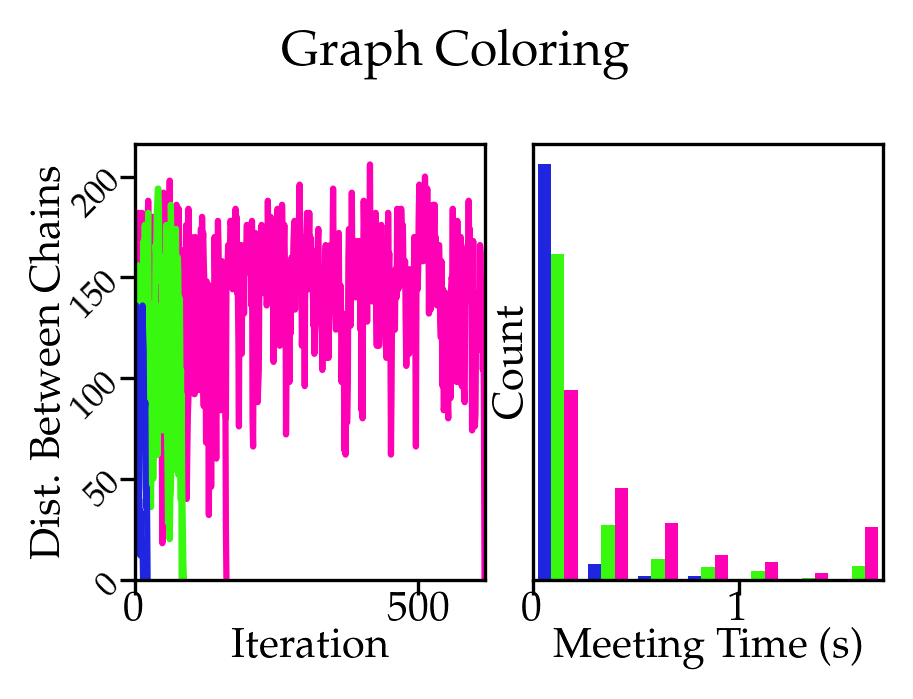

In [12]:
fn_base = "./figure1_results/N=25_p=0.2"
if not os.path.exists(fn_base):
    print("Will make directory %s" %fn_base)
    os.makedirs(fn_base)
    
traces_by_coupling_N25_p02 = copy.deepcopy(traces_by_coupling)
traces_fn = fn_base + "_traces.npy"
np.save(traces_fn, traces_by_coupling_N25_p02)

times_by_coupling_N25_p02 = copy.deepcopy(times_by_coupling)
times_fn = fn_base + "_meeting_times.npy"
np.save(times_fn, times_by_coupling_N25_p02)

title = "Graph Coloring"
utils.meeting_times_plots(
    traces_by_coupling, times_by_coupling, 
    couplings_plot=['Optimal', 'Maximal', 'Common_RNG'],
    couplings_colors=['#2025df', '#39f810','#fe01b5'], title=title, alpha=1.0, nbins=8, max_time=1.7,
    linewidth=1.5, iter_interval=None, n_traces_plot=2, max_iter=None
    )